In this notebook, I will demonstrate how to use existing SDSS software to create a commissioning design using a carton that already exists in targetdb. Specifically, we will be creating a design of all-skies.

# Creating Commissioning Designs

For this example, I will demonstrate how to create a design for a carton that is already in targetdb, specifically an all-sky design. First, we have to select all skies near some field center in targetdb.

In [1]:
from sdssdb.peewee.sdss5db import targetdb

# connect to targetdb
targetdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7502)

True

In [2]:
from peewee import *
import numpy as np

# set search radius based on field size for APO or LCO
observatory = 'APO'
if observatory == 'APO':
    r_search = 1.49
else:
    r_serach = 0.95

# specify the field center and position angle
racen = 20.
deccen = 20.
position_angle=24.188576

# specify the commissioning cartons we want to consider
cartons = ['ops_sky_boss', 'ops_sky_apogee']

# get all of the targets in the commissioning carton near the field center
all_skies = (targetdb.Target.select(targetdb.Target.catalogid,
                                   targetdb.Target.ra,
                                   targetdb.Target.dec,
                                   targetdb.Target.pk,
                                   targetdb.CartonToTarget.priority,
                                   targetdb.CartonToTarget.value,
                                   targetdb.Cadence.label,
                                   targetdb.Carton.carton,
                                   targetdb.CartonToTarget.pk,
                                   targetdb.Magnitude.g,
                                   targetdb.Magnitude.r,
                                   targetdb.Magnitude.i,
                                   targetdb.Magnitude.bp,
                                   targetdb.Magnitude.gaia_g,
                                   targetdb.Magnitude.rp,
                                   targetdb.Magnitude.h)
                    .join(targetdb.CartonToTarget)
                    .join(targetdb.Cadence, JOIN.LEFT_OUTER)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Carton)
                    .switch(targetdb.CartonToTarget)
                    .join(targetdb.Magnitude, JOIN.LEFT_OUTER)
                    .where((targetdb.Carton.carton.in_(cartons)) & 
                           (targetdb.Target.cone_search(racen, deccen, r_search))))

# grab the results
catalogid, ra, dec, target_pk, priority, value, cadences, carton, carton_to_target_pk, g, r, i, bp, gaia_g, rp, h  = map(list, zip(*list(all_skies.tuples())))
catalogid = np.array(catalogid, dtype=np.int64)
ra = np.array(ra)
dec = np.array(dec)
target_pk = np.array(target_pk, dtype=np.int64)
priority = np.array(priority)
value = np.array(value)
carton = np.array(carton)
carton_to_target_pk = np.array(carton_to_target_pk)
magnitudes = np.zeros((len(g),7))
magnitudes[:, 0] = g
magnitudes[:, 1] = r
magnitudes[:, 2] = i
magnitudes[:, 3] = bp
magnitudes[:, 4] = gaia_g
magnitudes[:, 5] = rp
magnitudes[:, 6] = h
# specify the instrument for each target
instrument = np.zeros(len(carton), dtype='<U10')
instrument[carton == 'ops_sky_boss'] = 'BOSS'
instrument[carton == 'ops_sky_apogee'] = 'APOGEE'

Next, we will want to create the design using using Robostrategy. First though, lets convert ra,dec to FPS x,y to visualize the possible targets. To do this, we will need to also specify the observation time of the design in Julian Days.

In [3]:
from coordio.utils import radec2wokxy
import robostrategy.obstime as obstime
import coordio.time

# specify observation time
ot = obstime.ObsTime(observatory=observatory.lower())
obsTime = coordio.time.Time(ot.nominal(lst=racen)).jd

# convert to x,y
x, y, fieldWarn, HA, PA_coordio = radec2wokxy(ra=ra,
                                              dec=dec,
                                              coordEpoch=np.array([2457174] * len(ra)),
                                              waveName=np.array(list(map(lambda x:x.title(), instrument))),
                                              raCen=racen,
                                              decCen=deccen,
                                              obsAngle=position_angle,
                                              obsSite=observatory,
                                              obsTime=obsTime)

[WARNING]: Warning! Wavelengths not supplied, defaulting to 6231 angstrom (CoordIOUserWarning)


To visualize our possible targets for the design, below is a plot of the possible targets in the FPS focal plane:

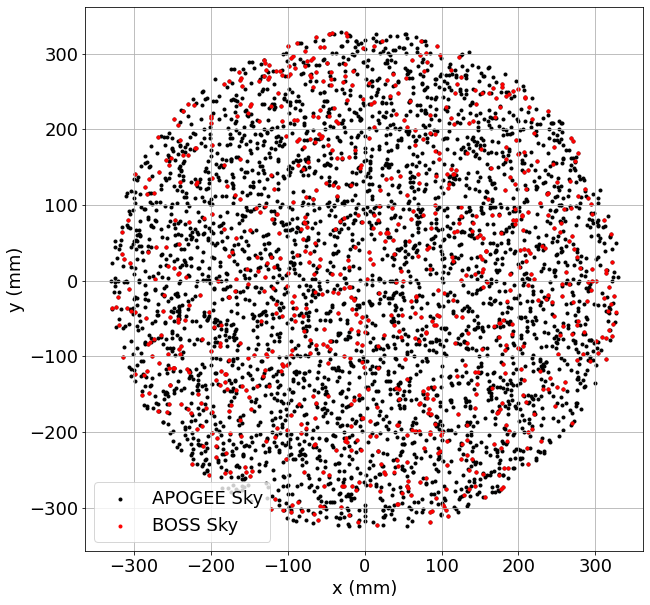

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,10))
plt.scatter(x[instrument == 'APOGEE'], y[instrument == 'APOGEE'],
            c='k', marker='.', label='APOGEE Sky')
plt.scatter(x[instrument == 'BOSS'], y[instrument == 'BOSS'],
            c='r', marker='.', label='BOSS Sky')
plt.grid()
plt.legend()
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

Now we can finally build the design. This requires that we create a specially formatted array for Robostrategy to build the design. This is demonstrated below.

In [8]:
import robostrategy.field as field
import roboscheduler.cadence as cadence
from sdssdb.peewee.sdss5db import targetdb

# connect to targetdb
targetdb.database.connect_from_parameters(user='sdss_user',
                                          host='localhost',
                                          port=7502)

# need to load cadences before building designs
cadence.CadenceList().fromdb(version='v1')
# cadencelist = cadence.CadenceList()
# cadencelist.fromfits(filename='rsCadences-test-designmode-2-apo.fits', unpickle=False)

# set cadence. must be in list of loaded cadences
# set cadence here because NONEs currently for sky carton in targetdb
cad = 'bright_1x1'

# create the field object
f = field.Field(racen=racen, deccen=deccen, pa=position_angle,
                field_cadence=cad, observatory=observatory.lower())

# set the required skies, in this case all fibers
f.required_calibrations['sky_boss'] = [375]
f.required_calibrations['sky_apogee'] = [125]
f.required_calibrations['standard_boss'] = [0]
f.required_calibrations['standard_apogee'] = [0]

# create array for RS field
N = len(ra)
# these are datatypes from robostrategy.Field
targets_dtype = np.dtype([('ra', np.float64),
                          ('dec', np.float64),
                          ('epoch', np.float32),
                          ('pmra', np.float32),
                          ('pmdec', np.float32),
                          ('parallax', np.float32),
                          ('lambda_eff', np.float32),
                          ('delta_ra', np.float64),
                          ('delta_dec', np.float64),
                          ('magnitude', np.float32, 7),
                          ('x', np.float64),
                          ('y', np.float64),
                          ('within', np.int32),
                          ('incadence', np.int32),
                          ('priority', np.int32),
                          ('value', np.float32),
                          ('program', np.unicode_, 30),
                          ('carton', np.unicode_, 50),
                          ('category', np.unicode_, 30),
                          ('cadence', np.unicode_, 30),
                          ('fiberType', np.unicode_, 10),
                          ('catalogid', np.int64),
                          ('carton_to_target_pk', np.int64),
                          ('rsid', np.int64),
                          ('target_pk', np.int64),
                          ('rsassign', np.int32)])

# create an empty array
targs = np.zeros(N, dtype=targets_dtype)

# fill in the relevant columns
targs['ra'] = ra
targs['dec'] = dec
targs['epoch'] = np.zeros(N, dtype=np.float32) + 2015.5
targs['x'] = x
targs['y'] = y
targs['within'] = np.zeros(N, dtype=np.int32) + 1
targs['incadence'] = np.zeros(N, dtype=np.int32) + 1
targs['priority'] = priority
targs['value'] = value
targs['program'] = np.array(['ops_sky'] * N, dtype='<U30')
targs['carton'] = carton
# set category. Can either be: 'sky_apogee', 'sky_boss', 'standard_apogee', 'standard_boss' or 'science'
category = np.zeros(len(carton), dtype='<U30')
category[carton == 'ops_sky_boss'] = 'sky_boss'
category[carton == 'ops_sky_apogee'] = 'sky_apogee'
targs['category'] = category
targs['cadence'] = np.array([cad] * N, dtype='<U30')
targs['fiberType'] = instrument
targs['lambda_eff'] = np.zeros(N, dtype=np.float32)
targs['lambda_eff'][targs['fiberType'] == 'APOGEE'] = 16000.
targs['lambda_eff'][targs['fiberType'] == 'BOSS'] = 5400.
targs['catalogid'] = catalogid
targs['carton_to_target_pk'] = carton_to_target_pk
targs['rsid'] = np.arange(N, dtype=np.int64) + 1
targs['target_pk'] = target_pk
targs['magnitude'] = magnitudes
targs['rsassign'] = np.zeros(N, dtype=np.int32) + 1

# assign targets
f.targets_fromarray(targs)

f.assign()

[WARNING]: Warning! Wavelengths not supplied, defaulting to 6231 angstrom (CoordIOUserWarning)
[WARNING]: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'. (FutureWarning)
[WARNING]: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison (FutureWarning)


You can print out the results of the assigments for the design to see how close Robostrategy got to the desired design.

In [9]:
print(f.assess())

Field cadence: bright_1x1

Calibration targets:
 sky_boss: 375/375
 standard_boss: 0/0
 sky_apogee: 70/125
 standard_apogee: 0/0

Science targets:
 BOSS targets assigned: 0
 APOGEE targets assigned: 0
 Targets per epoch: 0

Robots used:
 BOSS-only: 147
 APOGEE-BOSS: 298

Carton completion:




You can also plot the resulting assignments:

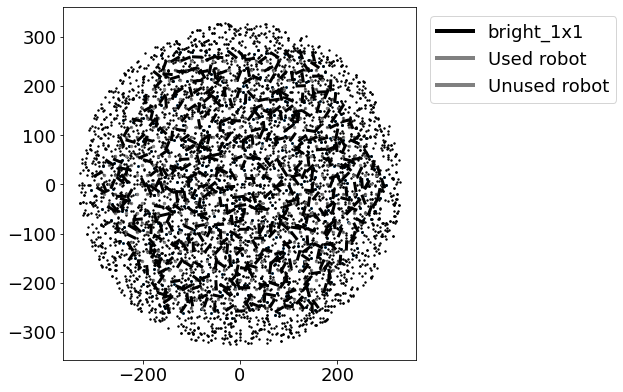

In [10]:
f.plot(iexp=0)

To save the design, you can then export it as a fits file.

In [11]:
f.tofits(filename='comm_all_skies_example.fits')

# Checking Commissioning Design with Mugatu

Finally, if you have created a design to your liking, you can validate the design once more using Mugatu. To do this, we will use the results of the above design to create a mugatu.FPSDesign object. Designs can be easily loaded directly from the fits file you created above.

In [12]:
from mugatu.fpsdesign import FPSDesign

# create a mugatu.FPSDesign object that is specified as a manual design
fps_design = FPSDesign(design_pk=-1,
                       obsTime=obsTime,
                       design_file='comm_all_skies_example.fits',
                       manual_design=True,
                       exp=0)

Once loaded you can validate the design. If no errors come up, your design is valid and passed all deadlock and collision tests!

In [13]:
fps_design.validate_design()

[WARNING]: Design does not meet minimum BOSS standards for DesignMode (MugatuWarning)
[WARNING]: Design does not meet minimum APOGEE standards for DesignMode (MugatuWarning)
[WARNING]: Design does not meet FOV criteria for BOSS standards for DesignMode (MugatuWarning)
[WARNING]: Design does not meet FOV criteria for APOGEE standards for DesignMode (MugatuWarning)


If any warnings come up (i.e. any assignment removed due to deadlocks or collisions), you can check which targets were removed by calling the below).

In [14]:
fps_design.targets_unassigned

[]

In [15]:
fps_design.targets_collided

[]